- Two Sample T-Tests (for an association between a quantitative variable and a binary categorical variable)
- ANOVA and Tukey Tests (for an association between a quantitative variable and a non-binary categorical variable)
- Chi-Square Tests (for an association between two categorical variables)

Two-Sample T-Test
Suppose that a company is considering a new color-scheme for their website. They think that visitors will spend more time on the site if it is brightly colored. To test this theory, the company shows the old and new versions of the website to 50 site visitors, each — and finds that, on average, visitors spent 2 minutes longer on the new version compared to the old. Will this be true of future visitors as well? Or could this have happened by random chance among the 100 people in this sample?

One way of testing this is with a 2-sample t-test. The null hypothesis for this test is that average length of a visit does not differ based on the color of the website. In other words, if we could observe all site visitors in two alternate universes (one where they see each version of the site), the average visiting times in these universes would be equal.

We can use SciPy’s ttest_ind() function to perform a 2-sample t-test. It takes the values for each group as inputs and returns the t-statistic and a p-value.

`from scipy.stats import ttest_ind`

`tstat, pval = ttest_ind(times_version1, times_version2)`

The company randomly sampled 100 site visitors. They showed the old version of their website to half of their sample and the new version to the other half. The amount of time (in minutes) that each visitor spent on the website was recorded.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv('../Datasets/version_time.csv')
data.head()

,time_minutes,version
0,11.92,new
1,12.90,old
2,13.76,old
3,15.68,old
4,16.28,old


In [3]:
new = data[data['version'] == 'new']['time_minutes']
old = data[data['version'] == 'old']['time_minutes']

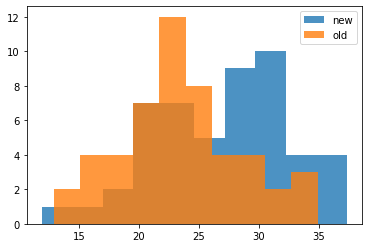

In [4]:
#Plot overlapping histograms
plt.hist(new, alpha = 0.8, label = 'new')
plt.hist(old, alpha = 0.8, label = 'old')
plt.legend()
plt.show()

There is a fair amount of overlap, but it does seem like visitors to the new website are spending slightly more time on the site (the orange distribution is shifted slightly to the right of the blue distribution).

In [5]:
print(np.mean(new))
print(np.mean(old))

26.884
23.53


In [6]:
#run the t-test here:
tstat, pval = ttest_ind(old, new)
print(pval)

0.0020408264429904


Since the p-value is less than 0.05, we can conclude there is a significant difference.

#### Multiple Tests
In the previous exercise, we used a two-sample t-test to investigate an association between a quantitative variable (time spent on a website) and a binary categorical variable (an old color scheme or a new color scheme).

In some circumstances, we might instead care about an association between a quantitative variable and a non-binary categorical variable (non-binary means more than two categories).

For example, suppose that we own a chain of stores that sell ants, called VeryAnts. There are three different locations: A, B, and C. We want to know whether customers are spending a significantly different amount per order at any of the locations.

There are three different comparisons we could make: A vs. B, B vs. C, and A vs. C. One way to answer our question is to simply run three separate 2-sample t-tests.

In [7]:
veryants = pd.read_csv('../Datasets/veryants.csv')
veryants.head(3)

,Sale,Store
0,73.57,A
1,38.37,A
2,49.36,A


In [8]:
veryants.tail(3)

,Sale,Store
447,46.77,C
448,70.39,C
449,42.06,C


In [9]:
a = veryants['Sale'][veryants['Store'] == 'A']
b = veryants['Sale'][veryants['Store'] == 'B']
c = veryants['Sale'][veryants['Store'] == 'C']

In [10]:
# run t-tests
tstat, a_b_pval = ttest_ind(a, b)
tstat, a_c_pval = ttest_ind(a, c)
tstat, b_c_pval = ttest_ind(b, c)
print('a_b_pval:', a_b_pval)
print('a_c_pval:', a_c_pval)
print('b_c_pval:', b_c_pval)

a_b_pval: 2.769886558708305e-05
a_c_pval: 0.02102938693149484
b_c_pval: 0.05986788486166067


In [11]:
# determine significance
a_b_significant = True
a_c_significant = True
b_c_significant = False

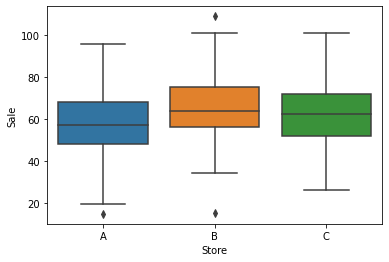

In [12]:
# create plot
sns.boxplot(data=veryants, x='Store', y='Sale')
plt.show()

It looks like the largest difference is between stores A and B (the orange box is clearly higher than the blue box). For the other comparisons (A vs. C and B vs. C), it’s a little harder to tell.

#### ANOVA
In the last exercise, we ran three separate 2-sample t-tests to investigate an association between a quantitative variable (amount spent per sale) and a non-binary categorical variable (location of VeryAnts visited, with options A, B, and C). The problem with this approach is that it inflates our probability of a type I error; the more tests we run, the worse the problem becomes!

In this situation, one approach is to instead use ANOVA (Analysis of Variance). ANOVA tests the null hypothesis that all groups have the same population mean (eg., the true average price of a sale is the same at every location of VeryAnts).

In Python, we can use the SciPy function f_oneway() to perform an ANOVA. f_oneway() has two outputs: the F-statistic (not covered in this course) and the p-value. If we were comparing scores on a video-game for math majors, writing majors, and psychology majors, we could run an ANOVA test with this line:

`from scipy.stats import f_oneway`

`fstat, pval = f_oneway(scores_mathematicians, scores_writers, scores_psychologists)`

If the p-value is below our significance threshold, we can conclude that at least one pair of our groups earned significantly different scores on average; however, we won’t know which pair until we investigate further!

In [13]:
# run ANOVA
from scipy.stats import f_oneway
fstat, pval = f_oneway(a, b, c)
print(pval)

0.00015355234908845413


At a 0.05 significance level, this p-value leads us to reject the null hypothesis (and conclude that at least one pair of stores have significantly different average sales)

#### Tukey's Range Test
Let’s say that we have performed an ANOVA to compare sales at the three VeryAnts stores. We calculated a p-value less than 0.05 and concluded that there is a significant difference between at least one pair of stores.

Now, we want to find out which pair of stores are different. This is where Tukey’s range test comes in handy!

In Python, we can perform Tukey’s range test using the statsmodels function pairwise_tukeyhsd(). For example, suppose we are again comparing video-game scores for math majors, writing majors, and psychology majors. We have a dataset named data with two columns: score and major. We could run Tukey’s range test with a type I error rate of 0.05 as follows:

`from statsmodels.stats.multicomp import pairwise_tukeyhsd`

`tukey_results = pairwise_tukeyhsd(data.score, data.major, 0.05)`

`print(tukey_results)`


<img src = 'image.png'>


Tukey’s range test is similar to running three separate 2-sample t-tests, except that it runs all of these tests simultaneously in order to preserve the type I error rate.

The function output is a table, with one row per pair-wise comparison. For every comparison where reject is True, we “reject the null hypothesis” and conclude there is a significant difference between those two groups. For example, in the output above, we would conclude that there is a significant difference between scores for math and writing majors, but no significant difference in scores for the other comparisons.

#### Assumptions of T-Tests, ANOVA, and Tukey
Before we use a two sample t-test, ANOVA, or Tukey’s range test, we need to be sure that the following things are true:

#### 1. The observations should be independently randomly sampled from the population
Suppose the population we are interested in is all visitors to a website. Random sampling will help ensure that our sample is representative of the population we care about. For example, if we only sample site visitors on Halloween, those visitors may behave differently from the general population. In practice, this can be a challenging assumption to meet, but it’s important to be aware of.

#### 2. The standard deviations of the groups should be equal
For example, if we’re comparing time spent on a website for two versions of a homepage, we first want to make sure that the standard deviation of time spent on version 1 is roughly equal to the standard deviation of time spent on version 2. To check this assumption, it is normally sufficient to divide one standard deviation by the other and see if the ratio is “close” to 1. Generally, a ratio between 0.9 and 1.1 should suffice.

That said, there is also a way to run a 2-sample t-test without assuming equal standard deviations — for example, by setting the equal_var parameter in the `scipy.stats.ttest_ind()` function equal to `False`. Running the test in this way has some disadvantages (it essentially makes it harder to reject the null hypothesis even when there is a true difference between groups), so it’s important to check for equal standard deviations before running the test.

#### 3. The data should be normally distributed…ish
Data analysts in the real world often still perform these tests on data that are not normally distributed. This is usually not a problem if sample size is large, but it depends on how non-normal the data is. In general, the bigger the sample size, the safer you are!

#### 4. The groups created by the categorical variable must be independent
Here are some examples where the groups are not independent:

- the number of goals scored per soccer player before, during, and after undergoing a rigorous training regimen (not independent because the same players are measured in each category)
- years of schooling completed by a group of adults compared to their parents (not independent because kids and their parents can influence one another)

Suppose that we want to run a two-sample t-test to compare the sample means for two groups (saved as dist_1 and dist_2 in the workspace).

Before running the test, we want to check whether the ratio of standard deviations for these groups is equal. Use the NumPy std() function to divide the standard deviation of dist_1 by the standard deviation of dist_2 and save the result as ratio, then print it out.

Are the standard deviations roughly equal?

0.6240550627217001


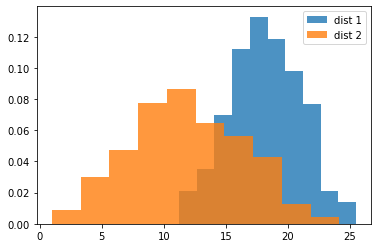

In [14]:
dist_1 = np.genfromtxt('../Datasets/1.csv')
dist_2 = np.genfromtxt('../Datasets/2.csv')

#calculate ratio of standard deviations:
ratio = np.std(dist_1)/np.std(dist_2)
print(ratio)

#check normality assumption
normal_assumption = True

#plot histograms of each distribution
plt.hist(dist_1, alpha = .8, density = True, label = 'dist 1')
plt.hist(dist_2, alpha = .8, density = True, label = 'dist 2')
plt.legend()
plt.show()

#### Chi-Square Test
If we want to understand whether the outcomes of two categorical variables are associated, we can use a Chi-Square test. It is useful in situations like:

- An A/B test where half of users were shown a green submit button and the other half were shown a purple submit button. Was one group more likely to click the submit button?
- People under and over age 40 were given a survey asking “Which of the following three products is your favorite?” Did these age groups have significantly different preferences?

In SciPy, we can use the function chi2_contingency() to perform a Chi-Square test. The input to chi2_contingency is a contingency table, which can be created using the pandas crosstab() function as follows:

#create table:
`import pandas as pd`

`table = pd.crosstab(variable_1, variable_2)`
 
#run the test:
`from scipy.stats import chi2_contingency`

`chi2, pval, dof, expected = chi2_contingency(table)`

For example, suppose we want to know whether gender is associated with the probability of a website visitor making a purchase. The null hypothesis is that there’s no association between the variables (eg. males, females, and non-binary people are all equally likely to make a purchase on the website, so gender and purchase-status are not associated). If the p-value is below our chosen threshold (often 0.05), we reject the null hypothesis and can conclude there is a statistically significant association between the two variables (eg. men, women, and non-binary people appear to have different probabilities of making a purchase, so gender is associated with purchase-status).

The management at the VeryAnts ant store wants to know if their two most popular species of ants, the Leaf Cutter and the Harvester, vary in popularity between 1st, 2nd, and 3rd graders.

We have provided a dataset named ants with a sample of 108 sales to 1st, 2nd, and 3rd grade teachers. The dataset has two columns: Grade (equal to '1st', '2nd', or '3rd') and Ant (equal to 'Leaf Cutter' or 'Harvester').

Use this data to create a contingency table of the Grade and Ant columns, and save the table as table.

In [15]:
# read in and print data
ants = pd.read_csv('../Datasets/ants_grade.csv')
print(ants.head())

  Grade          Ant
0   1st    harvester
1   2nd    harvester
2   2nd  leaf cutter
3   1st    harvester
4   3rd  leaf cutter


In [16]:
# create contingency table
table = pd.crosstab(ants.Grade, ants.Ant)
print(table)

Ant    harvester  leaf cutter
Grade                        
1st           28            8
2nd           31            5
3rd           23           13


In [17]:
# run Chi-Square test and print p-value
chi2, pval, dof, expected = chi2_contingency(table)
print(pval)
# determine significance
significant = False

0.08356116834982279


If the p-value is less than 0.05, then there is a significant association between these variables (the ant types differ in popularity across grades), so significant = True. If the p-value is greater than 0.05, significant = False

#### Assumptions of a Chi-Square Test
Before we use a Chi-Square test, we need to be sure that the following things are true:

#### 1. The observations should be independently randomly sampled from the population
This is also true of 2-sample t-tests, ANOVA, and Tukey. The purpose of this assumption is to ensure that the sample is representative of the population of interest.

#### 2. The categories of both variables must be mutually exclusive
In other words, individual observations should only fall into one category per variable. This means that categorical variables like “college major”, where students can have multiple different college majors, would not be appropriate for a Chi-Square test.

#### 3. The groups should be independent
Similar to 2-sample t-tests, ANOVA, and Tukey, a Chi-Square test also shouldn’t be used if either of the categorical variables splits observations into groups that can influence one another. For example, a Chi-Square test would not be appropriate if one of the variables represents three different time points.